⬆️ Upload your 'enriched_worst_200_with_flop_score.csv' file


Saving enriched_worst_200_with_flop_score.csv to enriched_worst_200_with_flop_score (7).csv
Loaded 25 movies
Flop distribution:
is_flop
0    14
1    11
Name: count, dtype: int64
Training set size: 18, Test set size: 7
--- Logistic Regression ---
Accuracy:  0.857
Precision: 0.750
Recall:    1.000
F1 Score:  0.857
ROC AUC:   0.917



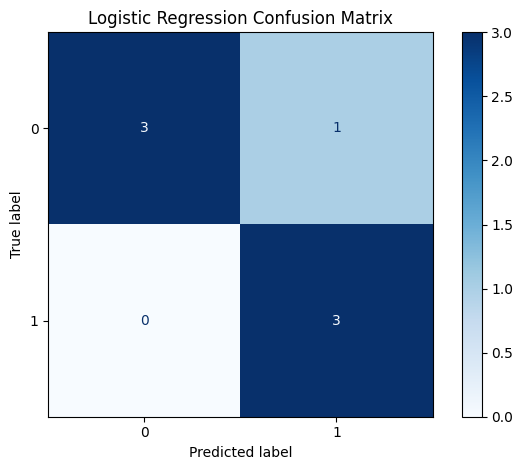

--- Random Forest ---
Accuracy:  0.857
Precision: 1.000
Recall:    0.667
F1 Score:  0.800
ROC AUC:   0.917



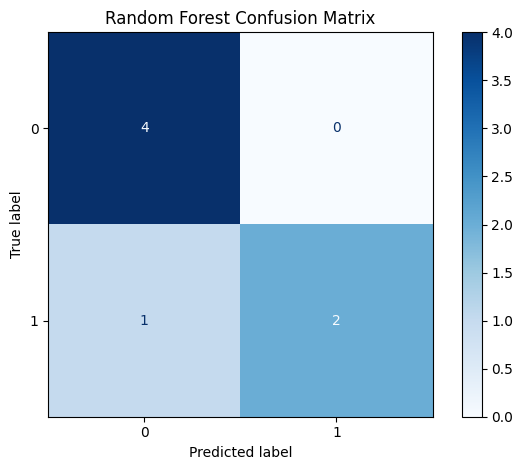

<ipython-input-8-da1fd5c27204>:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='coefficient', y='feature', palette='coolwarm')


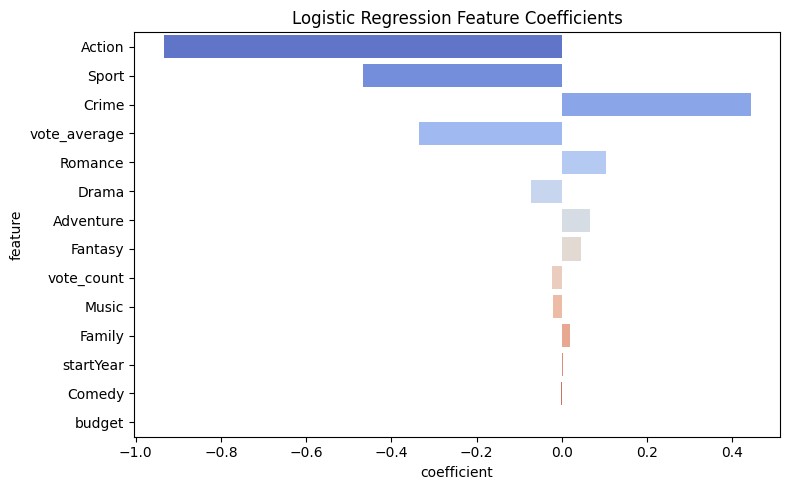

<ipython-input-8-da1fd5c27204>:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x='importance', y='feature', palette='viridis')


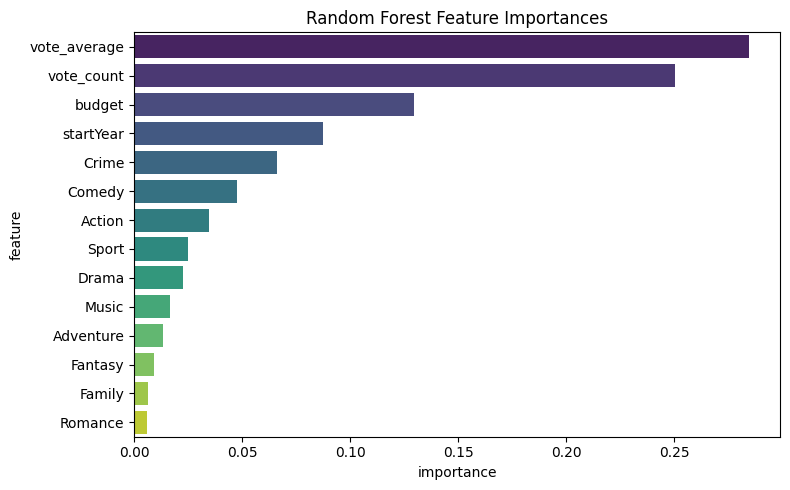

In [8]:
# Notebook 04: Predicting Movie Flops with Classification Models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

from google.colab import files

# ---- Load data ----
print("⬆️ Upload your 'enriched_worst_200_with_flop_score.csv' file")
uploaded = files.upload()

flops = pd.read_csv('enriched_worst_200_with_flop_score.csv')

print(f"Loaded {len(flops)} movies")

# ---- Define target ----
threshold = 50  # flop_score > 50% considered a flop
flops['is_flop'] = (flops['flop_score'] > threshold).astype(int)
print(f"Flop distribution:\n{flops['is_flop'].value_counts()}")

# ---- Feature selection ----
features = ['budget', 'vote_average', 'vote_count', 'startYear', 'genres']

# Handle missing values & clean
flops = flops.dropna(subset=features + ['is_flop'])

# ---- Preprocess genres (one-hot encode top genres) ----
all_genres = flops['genres'].dropna().str.split(',').explode()
top_genres = all_genres.value_counts().nlargest(10).index.tolist()

def encode_genres(row):
    genres = str(row).split(',')
    return {genre: int(genre in genres) for genre in top_genres}

genre_df = flops['genres'].apply(encode_genres).apply(pd.Series)

# ---- Combine features ----
X = pd.concat([
    flops[['budget', 'vote_average', 'vote_count', 'startYear']].reset_index(drop=True),
    genre_df.reset_index(drop=True)
], axis=1)

y = flops['is_flop']

# ---- Train/test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

# ---- Train Logistic Regression ----
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:,1]

# ---- Train Random Forest ----
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

# ---- Create visuals folder ----
os.makedirs('visuals', exist_ok=True)

# ---- Evaluation function with saved confusion matrix plot ----
def eval_model(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.3f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.3f}")
    print(f"ROC AUC:   {roc_auc_score(y_true, y_prob):.3f}")
    print()

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f'visuals/{model_name.lower().replace(" ", "_")}_confusion_matrix.png')
    plt.show()

# ---- Evaluate both models ----
eval_model(y_test, y_pred_lr, y_prob_lr, "Logistic Regression")
eval_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")

# ---- Feature importance ----
# Logistic Regression coefficients
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=coef_df, x='coefficient', y='feature', palette='coolwarm')
plt.title("Logistic Regression Feature Coefficients")
plt.tight_layout()
plt.savefig('visuals/logistic_regression_feature_coefficients.png')
plt.show()

# Random Forest feature importance
imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df, x='importance', y='feature', palette='viridis')
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.savefig('visuals/random_forest_feature_importances.png')
plt.show()
